In [129]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize

import cv2

In [130]:

def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels


In [131]:
path_out = './Data/'
files = glob.glob(path_out+"*")
files.sort()


In [132]:
dx= 5.106500953873407 
dt= 0.0016


data = []
first_filename = files[0]
for file in files:
   data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime('2024-05-07 ' + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)

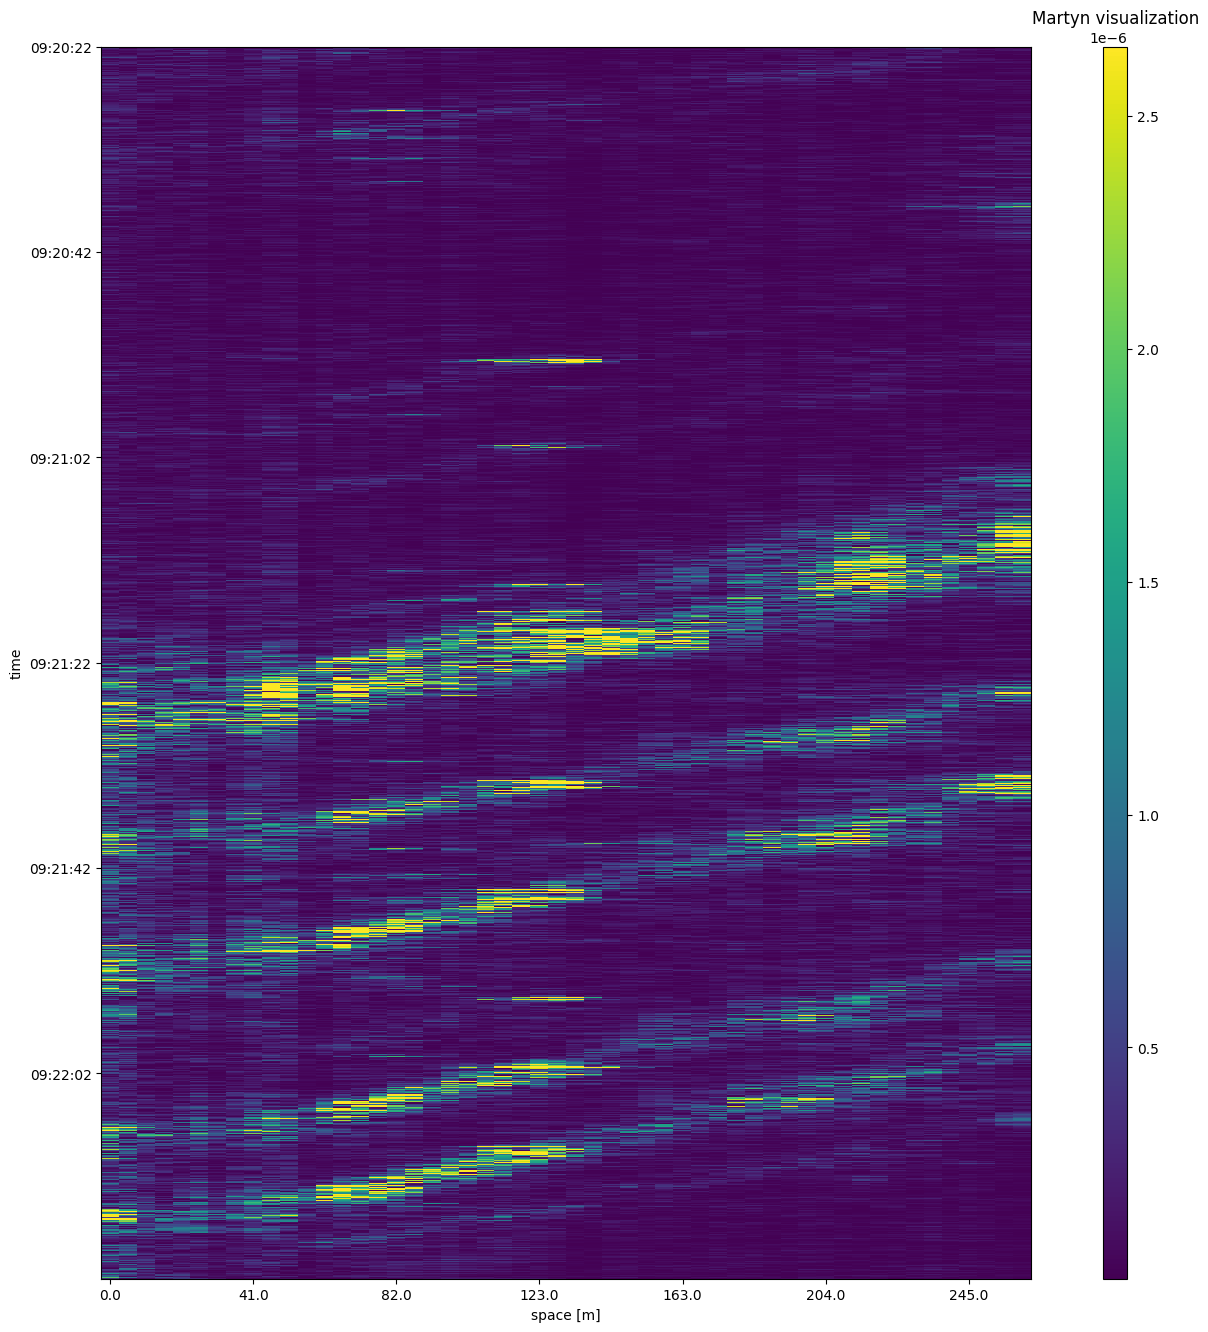

In [133]:


fig = plt.figure(figsize=(12,16))
ax = plt.axes()

# This is an example transformation and should be converted to the proper algorithm
df -= df.mean()
df = np.abs(df) 
low, high = np.percentile(df, [3, 99]) 
norm = Normalize(vmin=low, vmax=high, clip=True)

im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm)
plt.ylabel('time')
plt.xlabel('space [m]')

cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)
plt.title("Martyn visualization")
plt.show()

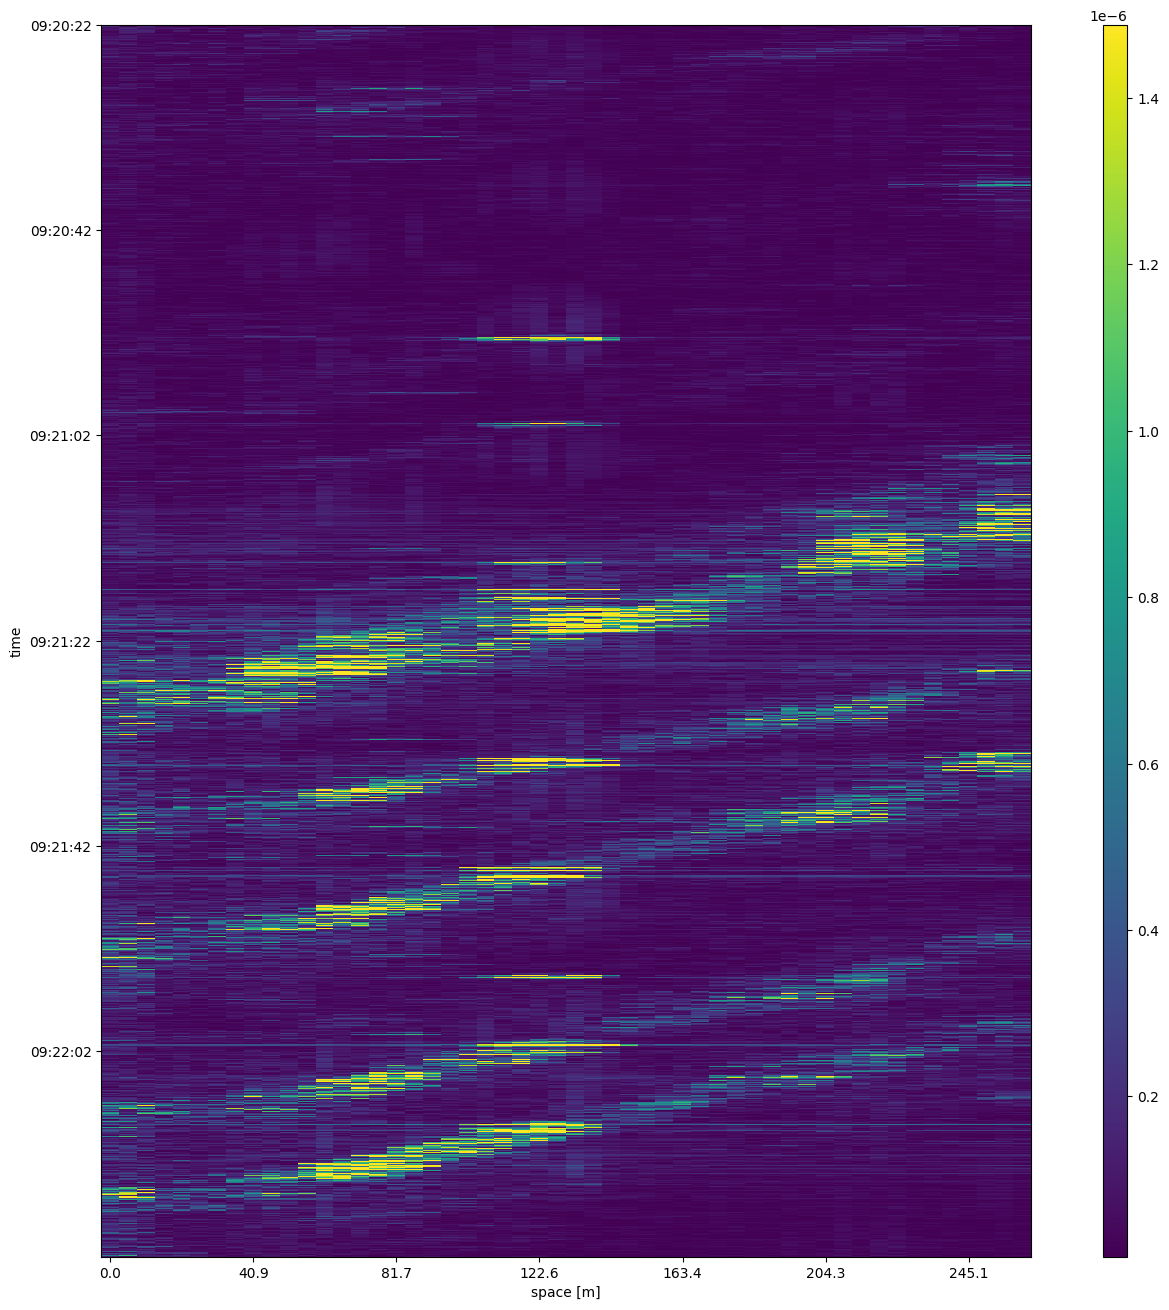

In [134]:
# Step 1: Remove mean and apply Fourier filtering
df = df.subtract(df.mean(axis=1), axis=0)  # Subtract temporal mean

# Fourier Transform for High-Pass Filtering
df_fft = np.fft.fft(df, axis=0)
df_fft[:10] = 0  # Remove low frequencies
df_filtered = np.fft.ifft(df_fft, axis=0).real
df = pd.DataFrame(df_filtered, index=df.index, columns=df.columns)

# Step 2: Signal Magnitude Enhancement
df = np.sqrt(df**2)  # Compute RMS values

# Step 3: Edge Detection
from skimage.filters import sobel
df_edges = sobel(df.values)  # Sobel edge detection
df = pd.DataFrame(df_edges, index=df.index, columns=df.columns)

# Step 4: Normalize Data for Visualization
low, high = np.percentile(df, [3, 99])  # Wider range for better contrast
norm = Normalize(vmin=low, vmax=high, clip=True)

# Step 5: Visualization
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 16))
ax = plt.axes()

im = ax.imshow(df, interpolation='none', aspect='auto', norm=norm, cmap='viridis')
plt.ylabel('time')
plt.xlabel('space [m]')

# Add colorbar
cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(im, cax=cax)

# Set axes labels
x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels, 1))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)

plt.show()


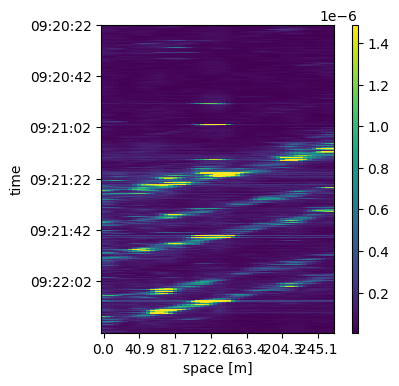

In [135]:
import cv2
import numpy as np

# Apply Gaussian blur
df_blurred = cv2.GaussianBlur(df.values, (5, 5), 0)  # (5, 5) is the kernel size; adjust as needed
df = pd.DataFrame(df_blurred, index=df.index, columns=df.columns)

# Re-visualize after Gaussian blur
fig = plt.figure(figsize=(3, 4))
ax = plt.axes()

im = ax.imshow(df, interpolation='none', aspect='auto', norm=norm, cmap='viridis')
plt.ylabel('time')
plt.xlabel('space [m]')

# Add colorbar
cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(im, cax=cax)

x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels, 1))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)

plt.show()


## Binary tresholding
Threshold the smoothed data to create a binary mask for detecting significant signal regions.

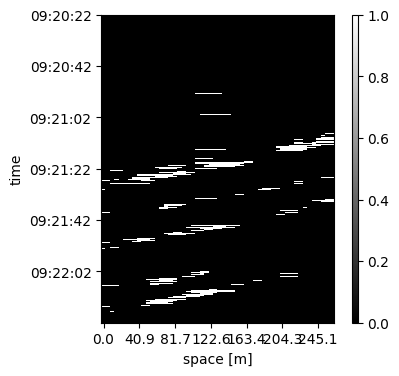

In [136]:
from skimage.filters import threshold_otsu

# Apply Otsu's thresholding
thresh = threshold_otsu(df.values)
binary_mask = df.values > thresh

# Visualize the binary mask
fig = plt.figure(figsize=(3, 4))
ax = plt.axes()

im = ax.imshow(binary_mask, interpolation='none', aspect='auto', cmap='gray')
plt.ylabel('time')
plt.xlabel('space [m]')

# Add colorbar
cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(im, cax=cax)

x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels, 1))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)

plt.show()


## Connecting fragments using Morphological operations
Small gaps in objects can be connected using morphological operations like dilation and closing. This is especially useful after thresholding to fix fragmented objects.

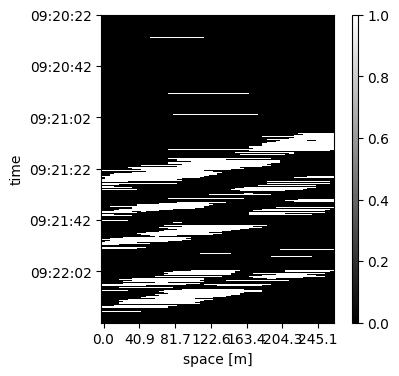

In [154]:
from skimage.morphology import binary_dilation, binary_erosion, binary_opening, binary_closing, disk

# Define a structuring element
selem = disk(3)  # You can adjust the size of the structuring element as needed

# Apply morphological operations
binary_dilated = binary_dilation(binary_mask, selem)
binary_eroded = binary_erosion(binary_dilated, selem)
binary_opened = binary_opening(binary_dilated, selem)
binary_closed = binary_closing(binary_opened, selem)
dilated2 = binary_dilation(binary_closed, selem)

# Visualize the result after morphological operations
fig = plt.figure(figsize=(3, 4))
ax = plt.axes()

im = ax.imshow(dilated2, interpolation='none', aspect='auto', cmap='gray')
plt.ylabel('time')
plt.xlabel('space [m]')

# Add colorbar
cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(im, cax=cax)

x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels, 1))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)

plt.show()

## Object Detection (Labeling)
Label connected regions in the binary mask to detect individual objects (slanted lines).

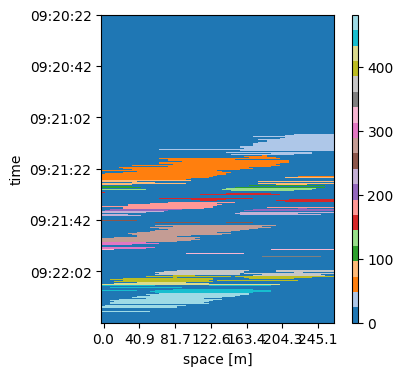

In [ ]:
from skimage.measure import label, regionprops

# Label connected regions in the binary mask
labels = label(binary_closed)

# Extract region properties for detected objects
regions = regionprops(labels)

# Visualize labeled regions
fig = plt.figure(figsize=(3, 4))
ax = plt.axes()

im = ax.imshow(labels, interpolation='none', aspect='auto', cmap='tab20')
plt.ylabel('time')
plt.xlabel('space [m]')

cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(im, cax=cax)

x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels, 1))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)

plt.show()


## Calculate Velocities
For each detected object (region), calculate velocity based on the slope of the slanted line.

Extract Bounding Boxes or Orientation: Use regionprops to get the bounding box or orientation of each object.

Calculate Velocity: Velocity is determined as:

v = \frac{\Delta x}{\Delta t} = \frac{\text{dx} \cdot (\text{end_col} - \text{start_col})}{\text{dt} \cdot (\text{end_row} - \text{start_row})}

In [151]:
dx = 5.106500953873407  # Spatial resolution (meters)
dt = 0.0016  # Temporal resolution (seconds)
min_size = 50  # Minimum region size (rows)

velocities = []
for region in regions:
    min_row, min_col, max_row, max_col = region.bbox
    delta_space = (max_col - min_col) * dx
    delta_time = (max_row - min_row) * dt

    # Compute velocity only for valid and sufficiently large regions
    if delta_time > 0 and (max_row - min_row) >= min_size:
        velocity = delta_space / delta_time
        velocities.append(velocity)
    else:
        velocities.append(0)  # Assign zero velocity for invalid cases

print("Corrected Object Velocities (m/s):", sorted(velocities))


Corrected Object Velocities (m/s): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

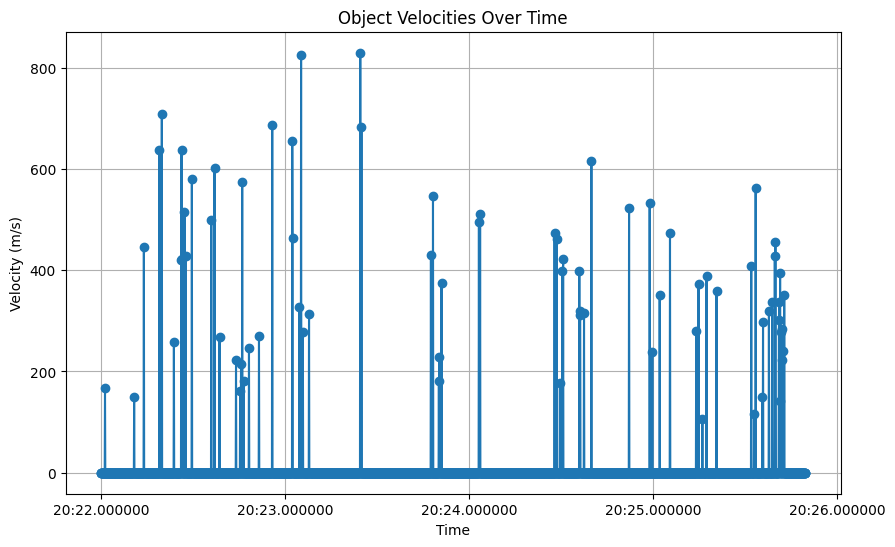

In [149]:
# Plot velocities
import matplotlib.pyplot as plt

time = df.index[:len(velocities)]  # Assuming velocities correspond to time slices
plt.figure(figsize=(10, 6))
plt.plot(time, velocities, marker='o')
plt.title("Object Velocities Over Time")
plt.xlabel("Time")
plt.ylabel("Velocity (m/s)")
plt.grid(True)
plt.show()
